In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("tab10")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
plt.style.use('seaborn-notebook')
params = {'legend.fontsize': 12,
          'legend.title_fontsize': 10,
          'figure.figsize': (10, 5),
         'axes.labelsize': 15,
         'axes.titlesize':18,
         'xtick.labelsize':15,
         'ytick.labelsize':15}
plt.rcParams.update(params)
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir("drive/MyDrive/ColabNotebooks/DemandPricing Project")

Mounted at /content/drive


In [3]:
df_feature = pd.read_csv("Features data set.csv")
df_sales = pd.read_csv("sales data-set.csv")
df_stores = pd.read_csv("stores data-set.csv")

In [4]:
df_feature[df_feature['Store'] == 1]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
177,1,28/06/2013,83.94,3.495,4205.98,796.70,6.84,3816.78,4812.74,NaN,NaN,False
178,1,05/07/2013,79.85,3.422,7649.99,3503.29,1766.77,9454.96,1079.89,NaN,NaN,False
179,1,12/07/2013,83.12,3.400,6089.94,1362.42,209.62,2367.42,2651.05,NaN,NaN,False
180,1,19/07/2013,79.26,3.556,3117.04,1060.39,199.05,1012.30,5381.72,NaN,NaN,False


In [5]:
df_sales[df_sales['Store'] == 1]

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False
...,...,...,...,...,...
10239,1,99,31/08/2012,20.06,False
10240,1,99,07/09/2012,0.05,True
10241,1,99,14/09/2012,0.03,False
10242,1,99,05/10/2012,635.00,False


In [6]:
df_sales.Date = pd.to_datetime(df_sales.Date)
df_feature.Date = pd.to_datetime(df_feature.Date)

df_sales = df_sales.sort_values('Date')
df_feature = df_feature.sort_values('Date')

In [7]:
df_feature = df_feature.merge(df_stores, on = 'Store')

In [8]:
df_feature = df_feature[df_feature.Date.dt.date <= df_sales.Date.dt.date.max()]

In [82]:
df = df_sales.merge(df_feature, on = ['Store','Date'], how = 'left')
df = df.drop('IsHoliday_x', axis = 1)
df=df.fillna(0)

In [83]:
df.columns = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'IsHoliday', 'Type', 'Size']

In [84]:
df['Year'] = df.Date.apply(lambda x: int(str(x)[:4]))
df['Month'] = df.Date.apply(lambda x: int(str(x)[5:7]))
df['Year-Month'] = df.Date.apply(lambda x: str(x)[:7])
df['Day'] = df.Date.apply(lambda x: int(str(x)[8:10]))

In [85]:
df

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Year,Month,Year-Month,Day
0,33,96,2010-01-10,7854.09,91.45,3.001,0.00,0.0,0.00,0.00,0.00,126.234600,9.265,False,A,39690,2010,1,2010-01,10
1,17,93,2010-01-10,3533.76,60.07,2.853,0.00,0.0,0.00,0.00,0.00,126.234600,6.885,False,B,93188,2010,1,2010-01,10
2,30,85,2010-01-10,43.92,70.28,2.603,0.00,0.0,0.00,0.00,0.00,211.329874,8.163,False,C,42988,2010,1,2010-01,10
3,30,87,2010-01-10,119.80,70.28,2.603,0.00,0.0,0.00,0.00,0.00,211.329874,8.163,False,C,42988,2010,1,2010-01,10
4,9,55,2010-01-10,6795.58,69.08,2.603,0.00,0.0,0.00,0.00,0.00,215.214134,6.560,False,B,125833,2010,1,2010-01,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1,82,2012-12-10,21963.11,62.99,3.601,2086.18,0.0,8.11,602.36,5926.45,223.381296,6.573,False,A,151315,2012,12,2012-12,10
421566,9,81,2012-12-10,2526.96,60.09,3.601,520.41,0.0,6.01,0.00,2839.84,227.169392,4.954,False,B,125833,2012,12,2012-12,10
421567,19,7,2012-12-10,27983.12,48.29,4.186,2374.50,0.0,7.25,919.32,6101.00,138.911700,7.992,False,A,203819,2012,12,2012-12,10
421568,2,95,2012-12-10,145394.36,60.97,3.601,2145.50,0.0,33.31,586.83,10421.01,223.015426,6.170,False,A,202307,2012,12,2012-12,10


(<Figure size 864x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d4373f0d0>)

(3.1, 3.45)

Text(0.5, 1.0, 'Change in fuel price with respect to type of store with holidays grouped')

Text(0, 0, '3.35')

Text(0, 0, '3.22')

Text(0, 0, '3.39')

Text(0, 0, '3.25')

Text(0, 0, '3.38')

Text(0, 0, '3.22')

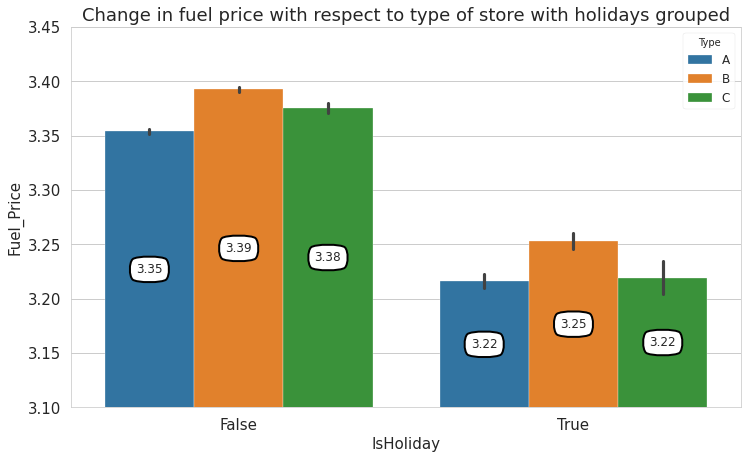

In [13]:
plt.subplots(figsize = (12,7))
plt.ylim(3.1,3.45)
plots = sns.barplot(data = df, x = 'IsHoliday', y = 'Fuel_Price', hue = 'Type')
plt.title('Change in fuel price with respect to type of store with holidays grouped')
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height() - (bar.get_height()-3.1)/2), ha='center', va='center',
                   size=12, xytext=(0, 0),bbox=dict(boxstyle="round4,pad=0.6", fc="w", ec="black", lw=2),
                   textcoords='offset points')

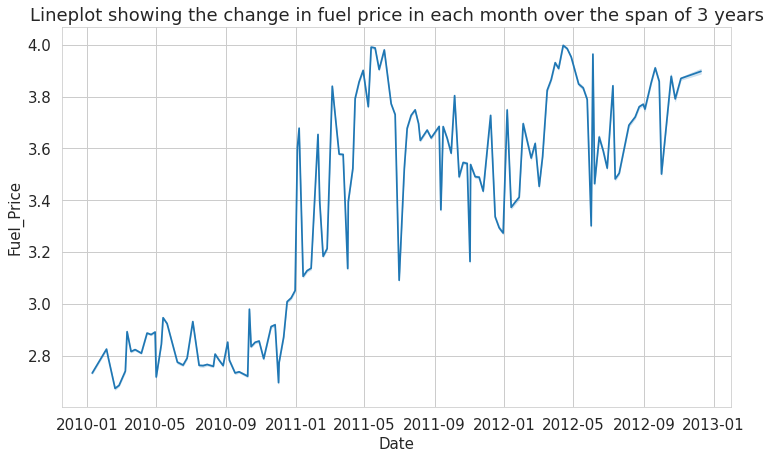

In [14]:
_ = plt.subplots(figsize = (12,7))
sns.lineplot(data = df, x = 'Date', y = 'Fuel_Price')
_ = plt.title('Lineplot showing the change in fuel price in each month over the span of 3 years')


(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7d4151ad50>)

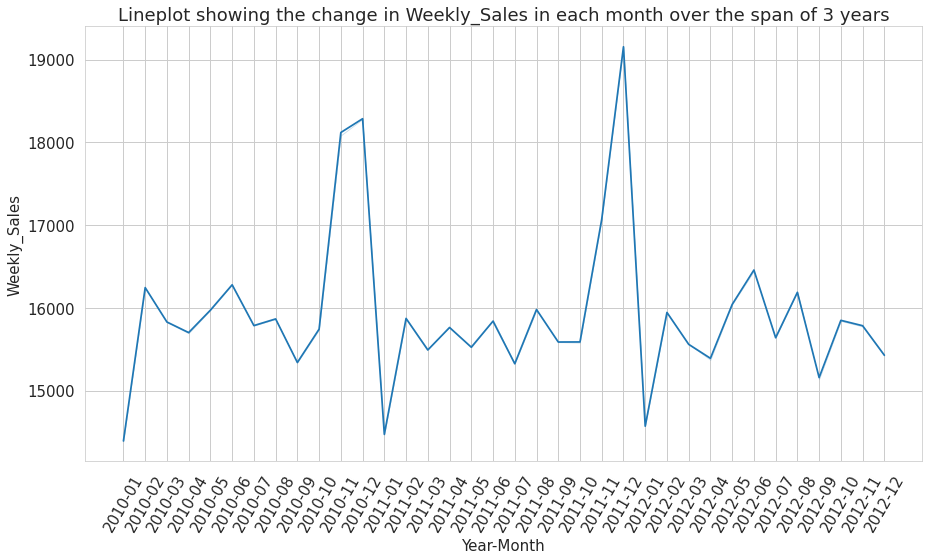

In [15]:
plt.subplots(figsize = (15,8))
_ = sns.lineplot(data = df, x = 'Year-Month', y = 'Weekly_Sales', ci = 1)
_ = plt.xticks(rotation = 60)
_ = plt.title('Lineplot showing the change in Weekly_Sales in each month over the span of 3 years')

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

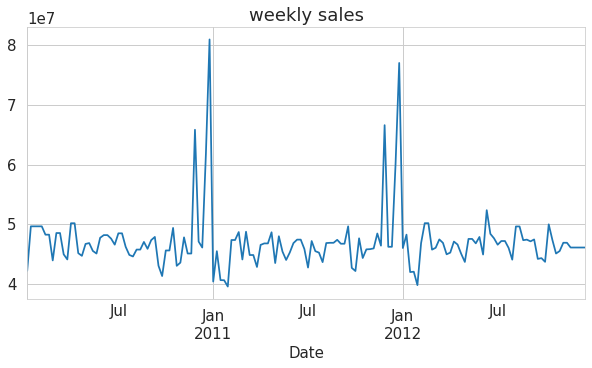

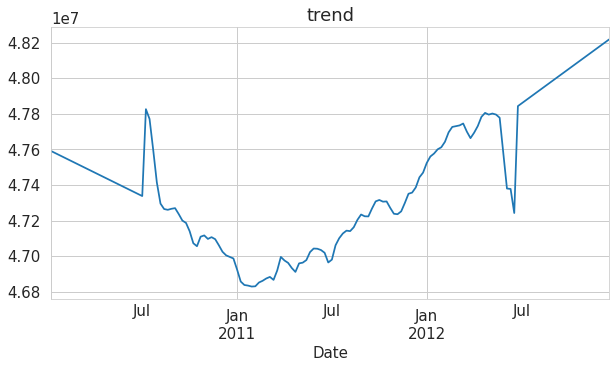

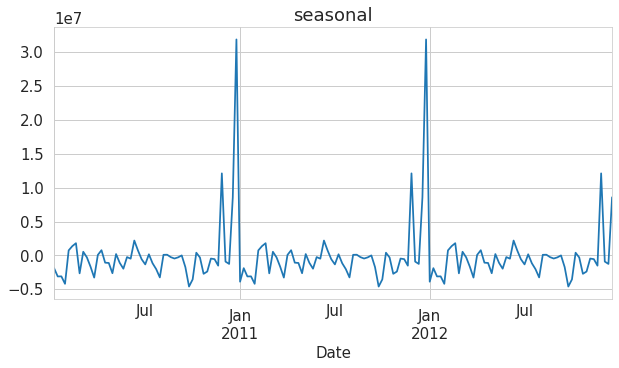

In [16]:
df_by_date = df.groupby('Date', as_index=False).agg({'Temperature': 'mean',
                                                        'Fuel_Price': 'mean',
                                                        'CPI': 'mean',
                                                        'Unemployment': 'mean', 
                                                        'Weekly_Sales': 'sum',
                                                        'IsHoliday': 'mean'})


df_by_date.Date = pd.to_datetime(df_by_date.Date, errors='coerce')
df_by_date.set_index('Date', inplace=True)


df_by_date_new = df_by_date.resample('W').mean().fillna(method='bfill')
multi_plot = seasonal_decompose(df_by_date_new['Weekly_Sales'], model = 'add', extrapolate_trend='freq')

plt.figure(figsize=(10,5))
multi_plot.observed.plot(title = 'weekly sales')

plt.figure(figsize=(10,5))
multi_plot.trend.plot(title = 'trend')

plt.figure(figsize=(10,5))
multi_plot.seasonal.plot(title = 'seasonal')


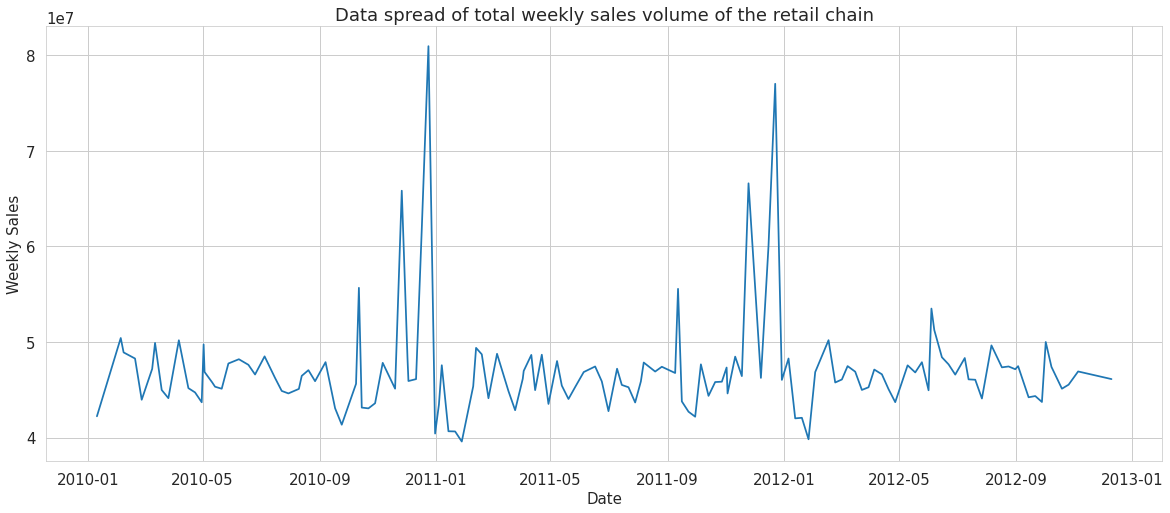

In [17]:
df_average_sales_week = df.groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df_average_sales = df_average_sales_week.sort_values('Weekly_Sales', ascending=False)

_ = plt.figure(figsize=(20,8))
_ = plt.plot(df_average_sales_week.Date, df_average_sales_week.Weekly_Sales)
_ = plt.title('Data spread of total weekly sales volume of the retail chain')
_ = plt.xlabel('Date')
_ = plt.ylabel('Weekly Sales')

In [18]:
df_top_stores = df.groupby(by=['Store'], as_index=False)['Weekly_Sales'].sum()
df_top_stores.sort_values('Weekly_Sales', ascending=False)[:5]

,Store,Weekly_Sales
19,20,3.013978e+08
3,4,2.995440e+08
13,14,2.889999e+08
12,13,2.865177e+08
1,2,2.753824e+08


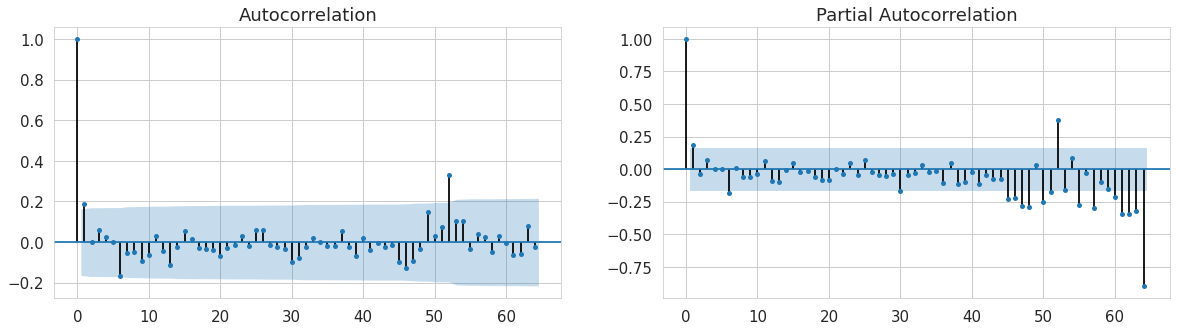

In [19]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf
ts = df_average_sales_week.set_index('Date')
fig, axes = plt.subplots(1,2, figsize=(20,5))
_ = plot_acf(ts, lags=64, ax=axes[0])
_ = plot_pacf(ts, lags=64, ax=axes[1])
plt.show()

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [21]:
fit_model = ExponentialSmoothing(df_by_date_new['Weekly_Sales'][:120],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

prediction = fit_model.forecast(34)
prediction

2012-04-29    4.379477e+07
2012-05-06    4.770069e+07
2012-05-13    4.501887e+07
2012-05-20    4.359155e+07
2012-05-27    4.497424e+07
2012-06-03    4.641249e+07
2012-06-10    4.684064e+07
2012-06-17    4.662833e+07
2012-06-24    4.497988e+07
2012-07-01    4.254695e+07
2012-07-08    4.663756e+07
2012-07-15    4.476842e+07
2012-07-22    4.421415e+07
2012-07-29    4.259594e+07
2012-08-05    4.536098e+07
2012-08-12    4.510648e+07
2012-08-19    4.502604e+07
2012-08-26    4.511555e+07
2012-09-02    4.449736e+07
2012-09-09    4.449613e+07
2012-09-16    4.615644e+07
2012-09-23    3.926887e+07
2012-09-30    3.928109e+07
2012-10-07    4.412782e+07
2012-10-14    4.166018e+07
2012-10-21    4.226160e+07
2012-10-28    4.201264e+07
2012-11-04    4.248714e+07
2012-11-11    4.425976e+07
2012-11-18    4.215393e+07
2012-11-25    6.221376e+07
2012-12-02    4.201085e+07
2012-12-09    4.189243e+07
2012-12-16    5.596518e+07
Freq: W-SUN, dtype: float64

<Figure size 1080x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weekly Sales (in millions)')

Text(0.5, 1.0, 'Weekly Sales Forecast')

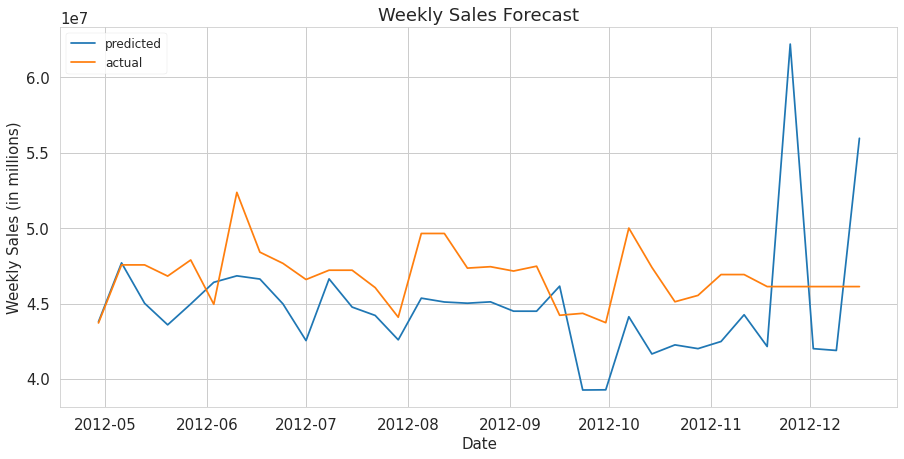

In [22]:
plt.figure(figsize=(15,7))
plt.plot(df_by_date_new.index[120:], prediction, label = 'predicted')
plt.plot(df_by_date_new.index[120:], df_by_date_new.Weekly_Sales[120:], label = 'actual')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Weekly Sales (in millions)")
plt.title("Weekly Sales Forecast")

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("Mean Absolute Percentage Error = {a}%".format(a=mean_absolute_percentage_error(df_by_date_new.Weekly_Sales[120:],prediction)))

Mean Absolute Percentage Error = 7.825287598743276%


In [24]:
fit_model = ExponentialSmoothing(df_by_date_new['Weekly_Sales'][:-2],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

future_prediction = fit_model.forecast(56)
future_prediction

2012-12-09    4.505660e+07
2012-12-16    5.929613e+07
2012-12-23    7.677893e+07
2012-12-30    4.339485e+07
2013-01-06    4.585048e+07
2013-01-13    4.055660e+07
2013-01-20    4.065700e+07
2013-01-27    3.887275e+07
2013-02-03    4.572178e+07
2013-02-10    4.812657e+07
2013-02-17    4.826579e+07
2013-02-24    4.372496e+07
2013-03-03    4.508220e+07
2013-03-10    4.544090e+07
2013-03-17    4.471307e+07
2013-03-24    4.276371e+07
2013-03-31    4.402774e+07
2013-04-07    4.555518e+07
2013-04-14    4.489303e+07
2013-04-21    4.404180e+07
2013-04-28    4.223444e+07
2013-05-05    4.599239e+07
2013-05-12    4.538030e+07
2013-05-19    4.442659e+07
2013-05-26    4.552566e+07
2013-06-02    4.362120e+07
2013-06-09    4.929049e+07
2013-06-16    4.612279e+07
2013-06-23    4.514523e+07
2013-06-30    4.380504e+07
2013-07-07    4.506481e+07
2013-07-14    4.459221e+07
2013-07-21    4.353146e+07
2013-07-28    4.170285e+07
2013-08-04    4.647859e+07
2013-08-11    4.633096e+07
2013-08-18    4.456831e+07
2

<Figure size 1080x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weekly Sales (in millions)')

Text(0.5, 1.0, 'Weekly Sales Forecast')

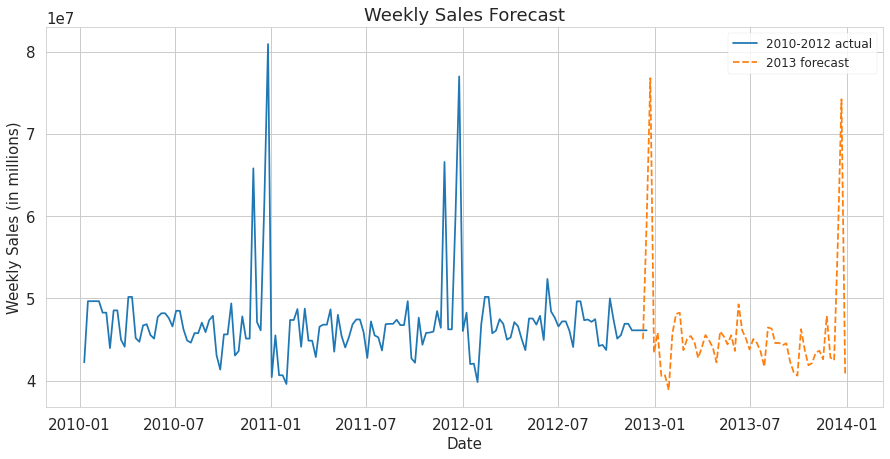

In [25]:
plt.figure(figsize=(15,7))
plt.plot(df_by_date_new.index, df_by_date_new.Weekly_Sales)
plt.plot(future_prediction, '--')
plt.legend(['2010-2012 actual', '2013 forecast'])
plt.xlabel("Date")
plt.ylabel("Weekly Sales (in millions)")
plt.title("Weekly Sales Forecast")

In [26]:
df_by_store_date = df.groupby(['Store', 'Date'], as_index=False).agg({'Temperature': 'mean',
                                                        'Fuel_Price': 'mean',
                                                        'CPI': 'mean',
                                                        'Unemployment': 'mean', 
                                                        'Weekly_Sales': 'sum',
                                                        'IsHoliday': 'mean'})
df_by_store_date.Date = pd.to_datetime(df_by_store_date.Date, errors='coerce')

In [27]:
df_by_store_date

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,IsHoliday
0,1,2010-01-10,71.89,2.603,211.671989,7.838,1453329.50,0.0
1,1,2010-02-04,62.27,2.719,210.820450,7.808,1594968.28,0.0
2,1,2010-02-07,80.91,2.669,211.223533,7.787,1492418.14,0.0
3,1,2010-02-19,39.93,2.514,211.289143,8.106,1611968.17,0.0
4,1,2010-02-26,46.63,2.561,211.319643,8.106,1409727.59,0.0
...,...,...,...,...,...,...,...,...
6430,45,2012-10-08,78.65,3.722,191.162613,8.684,733037.32,0.0
6431,45,2012-10-19,56.47,3.969,192.330854,8.667,718125.53,0.0
6432,45,2012-10-26,58.85,3.882,192.308899,8.667,760281.43,0.0
6433,45,2012-11-05,61.24,3.889,190.976417,8.567,770487.37,0.0


In [28]:
def fitHoltsWinter(df):
    fit_model = ExponentialSmoothing(df['Weekly_Sales'][:120],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

    prediction = fit_model.forecast(34)
#     print(df.Weekly_Sales[120:].shape, prediction.shape)
    return mean_absolute_percentage_error(df.Weekly_Sales[120:],prediction)
#     fit_model = ExponentialSmoothing(df_by_date_new['Weekly_Sales'][:-2],
#                                  trend = 'add',
#                                  seasonal = 'add',
#                                  seasonal_periods = 52).fit()

#     return fit_model
    

In [ ]:
mapes = []
for store_number in range(1, 46):
    df_sample_store = df_by_store_date[df_by_store_date['Store'] == store_number]
    df_sample_store.set_index('Date', inplace=True)
    

    df_sample_store = df_sample_store.resample('W').mean().fillna(method='bfill')
    mape = fitHoltsWinter(df_sample_store)
    print("Mean Absolute Percentage Error = {a} Store Number: {b}".format(a=mape, b=store_number))

    mapes.append(mape)

In [30]:
mapes = np.array(mapes)

In [31]:
lowest_mape = np.argmin(mapes)
highest_mape = np.argmax(mapes)
print(lowest_mape + 1, highest_mape + 1)

30 35


In [32]:
df_sample_store_min = df_by_store_date[df_by_store_date['Store'] == lowest_mape + 1]
df_sample_store_min.set_index('Date', inplace=True)


df_sample_store_min = df_sample_store_min.resample('W').mean().fillna(method='bfill')

df_sample_store_max = df_by_store_date[df_by_store_date['Store'] == highest_mape + 1]
df_sample_store_max.set_index('Date', inplace=True)


df_sample_store_max = df_sample_store_max.resample('W').mean().fillna(method='bfill')


<Figure size 1080x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weekly Sales ')

Text(0.5, 1.0, 'Weekly Sales Forecast for Store 44')

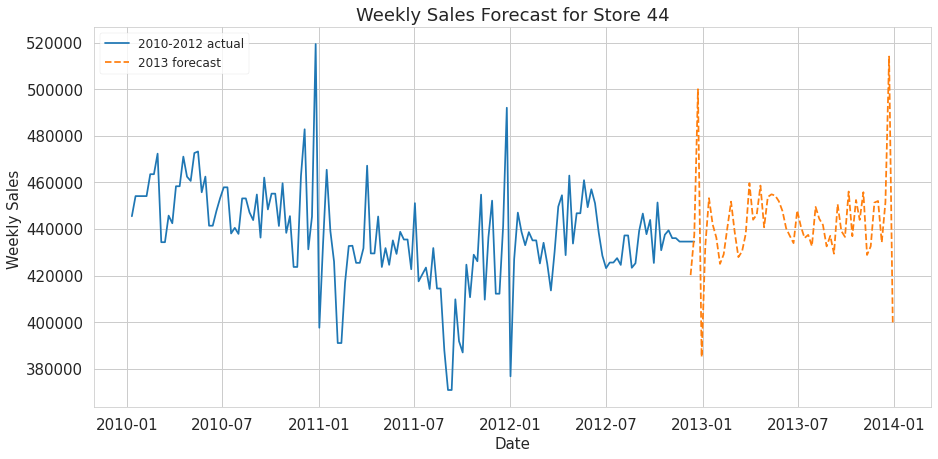

In [33]:
fit_model = ExponentialSmoothing(df_sample_store_min['Weekly_Sales'][:-2],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

future_prediction = fit_model.forecast(56)

plt.figure(figsize=(15,7))
plt.plot(df_sample_store_min.index, df_sample_store_min.Weekly_Sales)
plt.plot(future_prediction, '--')
plt.legend(['2010-2012 actual', '2013 forecast'])
plt.xlabel("Date")
plt.ylabel("Weekly Sales ")
plt.title("Weekly Sales Forecast for Store 44")

<Figure size 1080x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weekly Sales (in millions)')

Text(0.5, 1.0, 'Weekly Sales Forecast for Store 35')

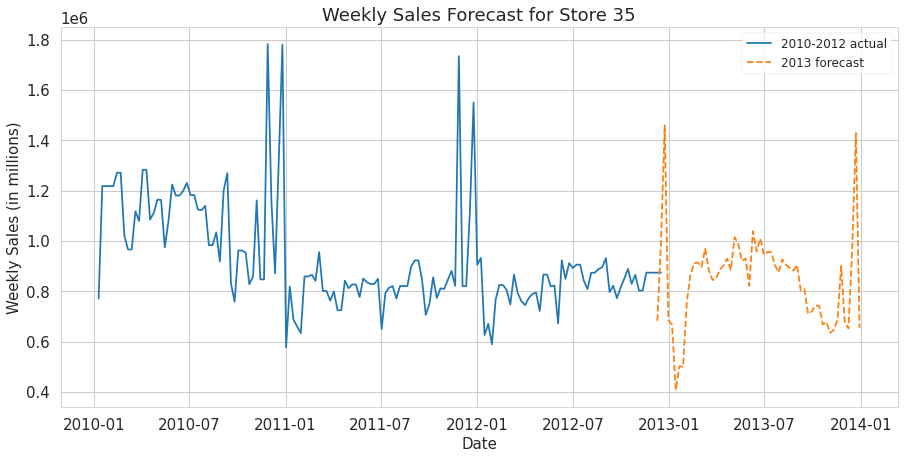

In [34]:
fit_model = ExponentialSmoothing(df_sample_store_max['Weekly_Sales'][:-2],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

future_prediction = fit_model.forecast(56)

plt.figure(figsize=(15,7))
plt.plot(df_sample_store_max.index, df_sample_store_max.Weekly_Sales)
plt.plot(future_prediction, '--')
plt.legend(['2010-2012 actual', '2013 forecast'])
plt.xlabel("Date")
plt.ylabel("Weekly Sales (in millions)")
plt.title("Weekly Sales Forecast for Store 35")

<Figure size 1080x504 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Weekly Sales (in millions)')

Text(0.5, 1.0, 'Weekly Sales Forecast for Store 20')

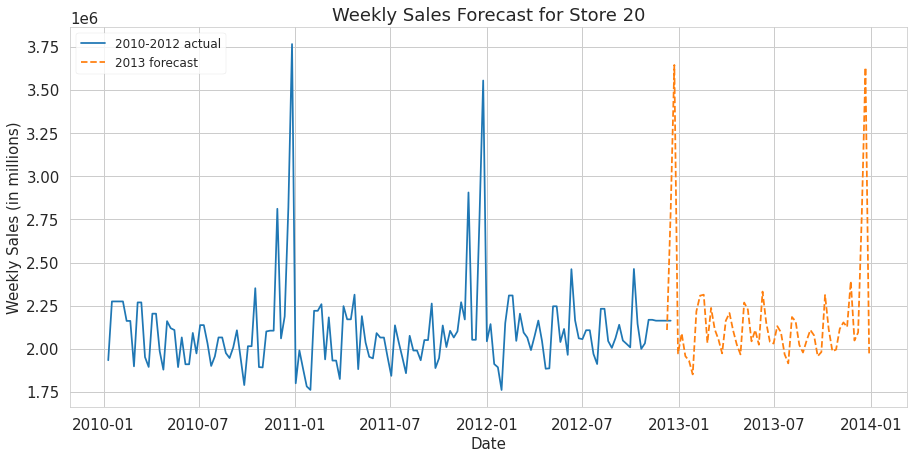

In [35]:
df_sample_store_top = df_by_store_date[df_by_store_date['Store'] == 20]
df_sample_store_top.set_index('Date', inplace=True)


df_sample_store_top = df_sample_store_top.resample('W').mean().fillna(method='bfill')

fit_model = ExponentialSmoothing(df_sample_store_top['Weekly_Sales'][:-2],
                                 trend = 'add',
                                 seasonal = 'add',
                                 seasonal_periods = 52).fit()

future_prediction = fit_model.forecast(56)

plt.figure(figsize=(15,7))
plt.plot(df_sample_store_top.index, df_sample_store_top.Weekly_Sales)
plt.plot(future_prediction, '--')
plt.legend(['2010-2012 actual', '2013 forecast'])
plt.xlabel("Date")
plt.ylabel("Weekly Sales (in millions)")
plt.title("Weekly Sales Forecast for Store 20")

## Markdown

In [113]:
df

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Unemployment,IsHoliday,Size,Year,Month,Year-Month,Day,Type_A,Type_B,Type_C
0,33,96,2010-01-10,7854.09,91.45,3.001,0.00,0.0,0.00,0.00,...,9.265,0,39690,2010,1,2010-01,10,1,0,0
1,17,93,2010-01-10,3533.76,60.07,2.853,0.00,0.0,0.00,0.00,...,6.885,0,93188,2010,1,2010-01,10,0,1,0
2,30,85,2010-01-10,43.92,70.28,2.603,0.00,0.0,0.00,0.00,...,8.163,0,42988,2010,1,2010-01,10,0,0,1
3,30,87,2010-01-10,119.80,70.28,2.603,0.00,0.0,0.00,0.00,...,8.163,0,42988,2010,1,2010-01,10,0,0,1
4,9,55,2010-01-10,6795.58,69.08,2.603,0.00,0.0,0.00,0.00,...,6.560,0,125833,2010,1,2010-01,10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,1,82,2012-12-10,21963.11,62.99,3.601,2086.18,0.0,8.11,602.36,...,6.573,0,151315,2012,12,2012-12,10,1,0,0
421566,9,81,2012-12-10,2526.96,60.09,3.601,520.41,0.0,6.01,0.00,...,4.954,0,125833,2012,12,2012-12,10,0,1,0
421567,19,7,2012-12-10,27983.12,48.29,4.186,2374.50,0.0,7.25,919.32,...,7.992,0,203819,2012,12,2012-12,10,1,0,0
421568,2,95,2012-12-10,145394.36,60.97,3.601,2145.50,0.0,33.31,586.83,...,6.170,0,202307,2012,12,2012-12,10,1,0,0


In [190]:
df_by_store_date = df.groupby(['Store', 'Date'], as_index=False).agg({'Year':'mean',
                                                                      'Month':'mean',
                                                                      'Day':'mean',
                                                                      'Temperature': 'mean',
                                                                      'Fuel_Price': 'mean',
                                                                      'CPI': 'mean',
                                                                      'Unemployment': 'mean', 
                                                                      'Weekly_Sales': 'sum',
                                                                      'MarkDown1' : 'sum',
                                                                      'MarkDown2' : 'sum',
                                                                      'MarkDown3' : 'sum',
                                                                      'MarkDown4' : 'sum',
                                                                      'MarkDown5' : 'sum',
                                                                      'IsHoliday': 'mean'})
df_by_store_date.Date = pd.to_datetime(df_by_store_date.Date, errors='coerce')
df_by_store_date = df_by_store_date.loc[:, df_by_store_date.columns!='Date']

In [217]:
from sklearn.inspection import permutation_importance
stores = df_by_store_date['Store'].unique()
results = dict()

for store in stores:
    train = df_by_store_date.loc[ (df_by_store_date['Year'].isin([2010, 2011])) & (df_by_store_date['Store']==store) ]
    test = df_by_store_date[~df_by_store_date['Year'].isin([2010, 2011]) & (df_by_store_date['Store']==store) ]
    X_train = train.drop(['Weekly_Sales'], axis = 1)
    y_train = train['Weekly_Sales']
    X_test = test.drop(['Weekly_Sales'], axis = 1)
    y_test = test['Weekly_Sales']
    
    reg = RandomForestRegressor() 
    reg.fit(X_train, y_train)
    yhat= reg.predict(X_test)
    mse = mean_absolute_percentage_error(y_test, yhat)

    imp = reg.feature_importances_
    #imp = permutation_importance(reg, X_test, y_test).importances_mean

    results['Store'+str(store)] = [mse, imp]

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

RandomForestRegressor()

In [218]:
X_train.columns

Index(['Store', 'Year', 'Month', 'Day', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'IsHoliday'],
      dtype='object')

In [219]:
results['Store44'][1]

array([0.        , 0.01914454, 0.0666071 , 0.14301455, 0.18145341,
       0.12585923, 0.38060825, 0.01968834, 0.01009867, 0.00098748,
       0.003193  , 0.0008918 , 0.03319142, 0.0152622 ])

In [220]:
results['Store35'][1]

array([0.        , 0.00176662, 0.02906728, 0.05170326, 0.05300504,
       0.09823441, 0.49570898, 0.05184284, 0.00279397, 0.00365713,
       0.16572374, 0.00565626, 0.01457069, 0.02626979])

In [221]:
dfdf = pd.DataFrame({'Store44': results['Store44'][1],
              'Store35': results['Store35'][1]})
dfdf.index = ['Store', 'Year', 'Month', 'Day', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'IsHoliday']

In [222]:
dfdf

,Store44,Store35
Store,0.000000,0.000000
Year,0.019145,0.001767
Month,0.066607,0.029067
Day,0.143015,0.051703
Temperature,0.181453,0.053005
Fuel_Price,0.125859,0.098234
CPI,0.380608,0.495709
Unemployment,0.019688,0.051843
MarkDown1,0.010099,0.002794
MarkDown2,0.000987,0.003657


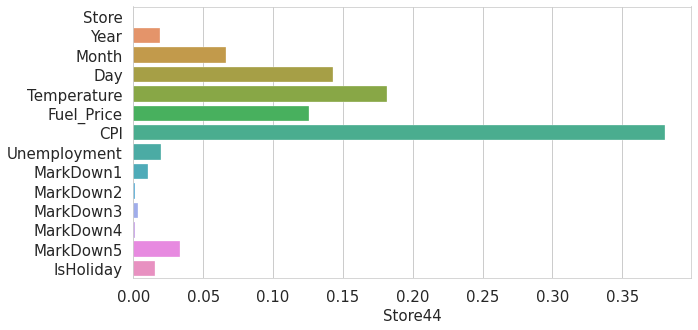

In [223]:
sns.barplot(x="Store44", y=dfdf.index, data=dfdf)

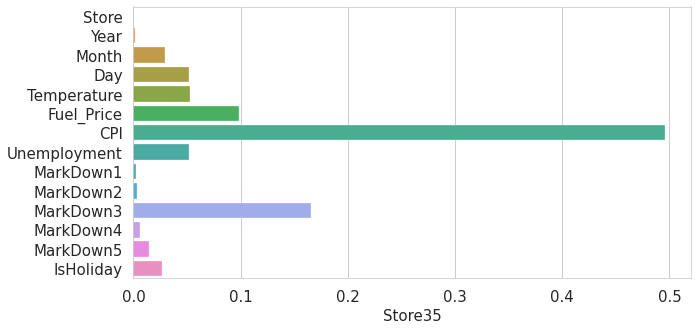

In [224]:
sns.barplot(x="Store35", y=dfdf.index, data=dfdf)